# Grupo 2 - Actividad 2: Filtros morfológicos

El objetivo de este notebook es la utilización de los filtros estudiados en clase sobre problemas reales. Se va a quitar el ruido sobre video.
Se ha probado a utilizar el fitro de mediana implementado en la Actividad 1 en un video pero el rendimiento de aplicarlo en tiempo real no era el esperado. Este vídeo simularía un entorno real como puede ser una cadena de producción donde nos encontramos con ruido electromagnético o ruido generado cuando hay poca luz.
Aplicando filtros morfológicos se consiguen resultados satisfactorios.

### Integrantes del grupo y participación en reuniones

| Fecha | Lilian Gutiérrez Méndez | Gabriel López Solar | David Goñi Burgos | Alejandro Núñez Valle | Alberto Martín Montero |
|:---:|:---:|:---:|:---:|:---:|:---:|
| 17/05/2021 | OK | OK | OK | OK | OK |
| 23/05/2021 | OK | OK | OK | OK | OK |
| 25/05/2021 | OK | OK | OK | OK | OK |

### Empezamos...

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random

In [2]:
def separar_canales_imagen_color(imag, canal):
    """Función para separar cada frame en canales"""    
    matriz = imag[:,:,canal] 
    return matriz  

In [3]:
def add_noise(imag,limite_inferior_random,limite_superior_random):
    """Función que simula el ruido generado en un entorno real"""
    filas,columnas = imag.shape
    numero_pixeles = random.randint(limite_inferior_random,limite_superior_random)
    for i in range(numero_pixeles):
        y_coord = random.randint(0,filas-1)
        x_coord = random.randint(0,columnas-1)
        imag[y_coord][x_coord] = 0
        
    numero_pixeles = random.randint(limite_inferior_random,limite_superior_random)
    for i in range(numero_pixeles):
        y_coord = random.randint(0,filas-1)
        x_coord = random.randint(0,columnas-1)
        imag[y_coord][x_coord] = 255
        
    return imag

In [4]:
def fusion_canales_imagen(canal_1, canal_2, canal_3):
    """Función para la fusión de canales"""
    imagen_fusion = cv2.merge([canal_1,canal_2,canal_3])    
    return imagen_fusion 

In [5]:
def morfo_apertura(imagen, alto_kernel, ancho_kernel):
    """Función que implementa la función apertura, es una erosión seguida de una dilatación."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(alto_kernel,ancho_kernel))
    imagen_apertura = cv2.morphologyEx(imagen,cv2.MORPH_OPEN,kernel)
    
    return imagen_apertura

In [6]:
def morfo_cierre(imagen, alto_kernel, ancho_kernel):
    """Función que implementa la función cierre, es una dilatación seguida de una erosión."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(alto_kernel,ancho_kernel))
    imagen_cierre = cv2.morphologyEx(imagen,cv2.MORPH_CLOSE,kernel)
    
    return imagen_cierre

In [7]:
def calcular_entropia(img):
    """Función que calcula la entropía del canal de la imagen recibido.
    Extraída de: https://github.com/zhaoxuhui/Entropy/blob/master/python/entropy.py"""
    entropy = []

    hist = cv2.calcHist([img], [0], None, [256], [0, 255])
    total_pixel = img.shape[0] * img.shape[1]

    for item in hist:
        probability = item / total_pixel
        if probability == 0:
            en = 0
        else:
            en = -1 * probability * (np.log(probability) / np.log(2))
        entropy.append(en)

    sum_en = np.sum(entropy)
    
    return sum_en


---
#### Función principal

De manera cíclica se captura el vídeo de la cámara conectada al ordenador, se separa cada fotograma en los canales R, G y B y se aplica, primero un filtro de apertura para eliminar el ruido de background, y después un filtro de cierre para eliminar el de foreground.

En el momento en el que se pulse la tecla "C" se realiza una captura del fotograma actual del vídeo con ruido y del vídeo filtrado, y se guardan para su posterior análisis.

Si se pulsa la tecla "S" se finaliza la ejecución.

In [16]:
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

capture = cv2.VideoCapture(0)

while (capture.isOpened()):
    
    ret, img = capture.read()
    
    if ret == True:
        # Llamada a la función para separar la imagen en los 3 canales
        img_B = separar_canales_imagen_color(img, 0)
        img_G = separar_canales_imagen_color(img, 1)
        img_R = separar_canales_imagen_color(img, 2)
        
        # Se añade ruido a estos canales. 
        img_ruido_B = add_noise(img_B, 8000, 10000)
        img_ruido_G = add_noise(img_G, 8000, 10000)
        img_ruido_R = add_noise(img_R, 8000, 10000)
        
        # Se fusionan los canales con ruido para sacar la imagen en color.
        img_ruido = fusion_canales_imagen(img_ruido_B, img_ruido_G, img_ruido_R)
        
        # Se aplica el filtro morfológico de apertura, que elimina ruido en el background.
        img_apertura_B = morfo_apertura(img_ruido_B, 2, 2)
        img_apertura_G = morfo_apertura(img_ruido_G, 2, 2)
        img_apertura_R = morfo_apertura(img_ruido_R, 2, 2)
        
        # Se fusionan los canales con el filtro de apertura para sacar la imagen en color.
        img_apertura = fusion_canales_imagen(img_apertura_B, img_apertura_G, img_apertura_R)
        
        # Sobre los canales anteriores, se aplica un filtro de cierre, que elimina el ruido de foreground.
        img_filtro_B = morfo_cierre(img_apertura_B, 2, 2)
        img_filtro_G = morfo_cierre(img_apertura_G, 2, 2)
        img_filtro_R = morfo_cierre(img_apertura_R, 2, 2)
        
        # Se fusionan los canales con el filtro de apertura para sacar la imagen en color.
        img_filtro = fusion_canales_imagen(img_filtro_B, img_filtro_G, img_filtro_R)

        # Visualización del video con ruido
        cv2.imshow('Video con ruido', img_ruido)

        # Visualización del vídeo corregido con el filtro
        cv2.imshow('Video filtrado', img_filtro)
        

    accion = cv2.waitKey(1) & 0xFF
    
    if (accion == ord('c')) or (accion == ord('C')):
        
        print("Imagen capturada")
        
        # Se transforma a RGB cada una de las capturas y se guardan
        img_captura_ruido = cv2.cvtColor(img_ruido.copy(),cv2.COLOR_BGR2RGB)
        cv2.imwrite('imagen_captura_ruido.jpg', img_captura_ruido)
        img_captura_filtro = cv2.cvtColor(img_filtro.copy(),cv2.COLOR_BGR2RGB)
        cv2.imwrite('imagen_captura_filtro.jpg', img_captura_filtro)
        
        # Se visualizan ambas capturas
        fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,4))
        ax0.imshow(img_captura_ruido), ax0.set_title('Captura del vídeo con ruido')
        ax0.axis('off')
        ax1.imshow(img_captura_filtro), ax1.set_title('Captura del vídeo filtrado')
        ax1.axis('off')
        fig.tight_layout()
        
    if (accion == ord('s')) or (accion == ord('S')):
        plt.close()
        break
        
capture.release()
cv2.destroyAllWindows()

Imagen capturada


---
### Comprobación del resultado obtenido

Las imágenes capturadas del vídeo se van a cargar para visualizarlas y comprobar la eficacia del filtrado

In [17]:
def printHistograma(img1, img2):
    """Función para visualizar cada uno de los histogramas separados por canales"""
    img1_r,img1_g,img1_b = cv2.split(img1)
    img2_r,img2_g,img2_b = cv2.split(img2)
    
    plt.subplot(3,1,1)
    plt.title("Histograma de la captura de vídeo con ruido")
    plt.xlabel('intensidad')
    plt.ylabel('pixeles')
    plt.hist(img1_r.ravel(),255,(0,255),color='red')
    plt.subplot(3,1,2)
    plt.xlabel('intensidad')
    plt.ylabel('pixeles')
    plt.hist(img1_g.ravel(),255,(0,255),color='green')
    plt.subplot(3,1,3)
    plt.xlabel('intensidad')
    plt.ylabel('pixeles')
    plt.hist(img1_b.ravel(),255,(0,255),color='blue')
    plt.show()


    plt.subplot(3,1,1)
    plt.title("Histograma de la captura de vídeo filtrado")
    plt.xlabel('intensidad')
    plt.ylabel('pixeles')
    plt.hist(img2_r.ravel(),255,(0,255),color='red')
    plt.subplot(3,1,2)
    plt.xlabel('intensidad')
    plt.ylabel('pixeles')
    plt.hist(img2_g.ravel(),255,(0,255),color='green')
    plt.subplot(3,1,3)
    plt.xlabel('intensidad')
    plt.ylabel('pixeles')
    plt.hist(img2_b.ravel(),255,(0,255),color='blue')
    plt.show()

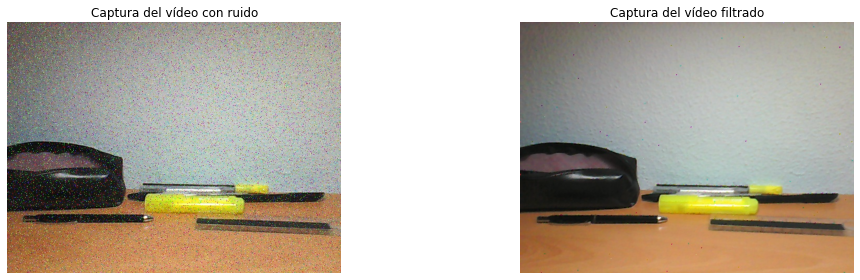

Entropia del canal R la imagen con ruido:  [7.36608083]
Entropia del canal R la imagen corregida:  [7.06569751]
-------------------------------------------------------
Entropia del canal G la imagen con ruido:  [7.48663441]
Entropia del canal G la imagen corregida:  [7.2263931]
-------------------------------------------------------
Entropia del canal B la imagen con ruido:  [7.62559287]
Entropia del canal B la imagen corregida:  [7.33656402]


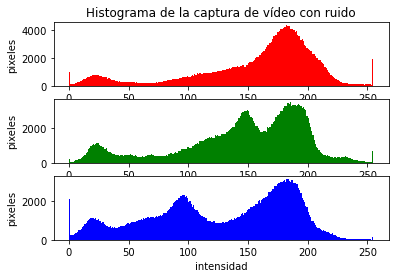

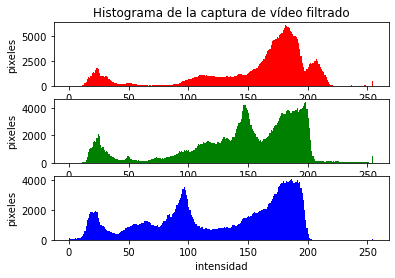

In [18]:
img_captura_ruido = cv2.imread('imagen_captura_ruido.jpg', cv2.COLOR_BGR2RGB)
(img_captura_ruido_R, img_captura_ruido_G, img_captura_ruido_B) = cv2.split(img_captura_ruido)

img_captura_filtro = cv2.imread('imagen_captura_filtro.jpg', cv2.COLOR_BGR2RGB)
(img_captura_filtro_R, img_captura_filtro_G, img_captura_filtro_B) = cv2.split(img_captura_filtro)

# Se visualizan ambas capturas
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 4))
ax0.imshow(img_captura_ruido), ax0.set_title('Captura del vídeo con ruido')
ax0.axis('off')
ax1.imshow(img_captura_filtro), ax1.set_title('Captura del vídeo filtrado')
ax1.axis('off')
fig.tight_layout()
plt.show()

# Se calcula la entropía de cada uno de los canales
print("Entropia del canal R la imagen con ruido: " , calcular_entropia(img_captura_ruido_R))
print("Entropia del canal R la imagen corregida: " , calcular_entropia(img_captura_filtro_R))
print("-------------------------------------------------------")
print("Entropia del canal G la imagen con ruido: " , calcular_entropia(img_captura_ruido_G))
print("Entropia del canal G la imagen corregida: " , calcular_entropia(img_captura_filtro_G))
print("-------------------------------------------------------")
print("Entropia del canal B la imagen con ruido: " , calcular_entropia(img_captura_ruido_B))
print("Entropia del canal B la imagen corregida: " , calcular_entropia(img_captura_filtro_B))

# Se visualizan los histogramas
printHistograma(img_captura_ruido, img_captura_filtro)

Como se puede observar, la entropía se reduce en todos los canales de la imagen tras aplicar el filtro y, además, los valores anómalos (outliers) disminuyen considerablemente en el histograma.